# Imports

In [1]:
import keras
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing import image
from keras.optimizers import Nadam
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

Using TensorFlow backend.


In [2]:
%matplotlib inline

# Load MNIST data and convert to desired format

In [3]:
from keras import backend as K
from keras.datasets import mnist as mnist_dataset

class MNISTImages:
    def __init__(self):
        img_rows = img_cols = 28
        
        (X_train, y_train), (X_test, y_test) = mnist_dataset.load_data()

        if K.image_dim_ordering() == 'th':
            X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
            X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
            X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)
            
        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')
        X_train /= 255
        X_test /= 255
            
        self.train_input = X_train
        self.train_labels = self.to_categorical(y_train)
        
        self.test_input = X_test
        self.test_labels = self.to_categorical(y_test)
        
    def to_categorical(self,y):
        y = np.array(y, dtype='int').ravel()
        nb_classes = np.max(y) + 1
        n = y.shape[0]
        categorical = np.zeros((n, nb_classes))
        categorical[np.arange(n), y] = 1
        return categorical
        

# Build modell

In [4]:
def getModel():
    return Sequential([
        BatchNormalization(input_shape=(28,28,1), axis=3),
        Convolution2D(10,3,3, border_mode='same', activation='relu'),
        Convolution2D(10,3,3, border_mode='same', activation='relu'),
        BatchNormalization(axis=3),
        Dropout(0.1),
        MaxPooling2D(pool_size=(2,2)),
        Convolution2D(20,3,3, border_mode='same', activation='relu'),
        Dropout(0.2),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.45),
        Dense(10),
        Activation('softmax')
    ])

In [5]:
model = getModel()
opt = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.006)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
mnist = MNISTImages()

### Load training and test data

In [7]:
train_generator = image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    dim_ordering='tf'
).flow(mnist.train_input, mnist.train_labels, batch_size=512)

test_generator = image.ImageDataGenerator().flow(mnist.test_input, mnist.test_labels)

### Train model

In [8]:
#model.fit_generator(
#        train_generator, 
#        samples_per_epoch=len(mnist.train_labels),
#        nb_epoch=24, 
#        validation_data=test_generator, 
#        nb_val_samples=len(mnist.test_labels)
#    )

### Load weights from previous training

In [9]:
model.load_weights('/data/trained_models/mnist/v0.3.h5')

In [10]:
print(model.evaluate(mnist.test_input, mnist.test_labels, verbose=0))

[0.018297616404833388, 0.99399999999999999]


# Examine results

In [28]:
import math
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None, sub_titles=None, grayscale=False, cmap=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, math.ceil(len(ims)/rows), i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=14)
        if sub_titles is not None:
            sp.set_title(str(titles[i]) + " (" + str(sub_titles[i]) + ")", fontsize=14)
        plt.imshow(ims[i].reshape((28,28)), interpolation=None if interp else 'none', cmap=cmap)

### Random examples

In [36]:
preview_generator = image.ImageDataGenerator().flow(mnist.test_input, mnist.test_labels, batch_size=10, shuffle=True)
imgs, original_label_ids = next(preview_generator)
preds = model.predict(imgs)
labels = (np.argmax(preds, axis=1))
original_labels = (np.argmax(original_label_ids, axis=1))

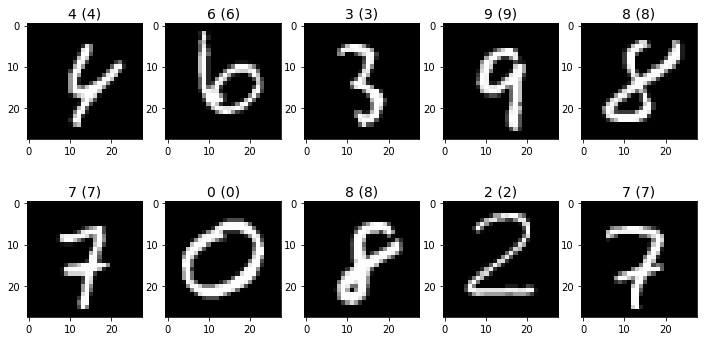

In [37]:
plots(imgs, titles=labels, sub_titles=original_labels, rows=2, cmap='gray')

### Generate all predictions for the test set

In [12]:
test_set_prediction_generator = image.ImageDataGenerator().flow(mnist.test_input, mnist.test_labels, batch_size=512, shuffle=False)
test_predictions = model.predict_generator(test_set_prediction_generator, len(mnist.test_labels))
predicted_test_labels = np.argmax(test_predictions, axis=1)
original_test_labels = np.argmax(mnist.test_labels, axis=1)

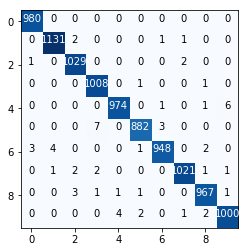

In [50]:
cm = confusion_matrix(original_test_labels,predicted_test_labels)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

### Wrong predictions

In [63]:
wrong_answers_idx = np.where(original_test_labels != predicted_test_labels)[0]

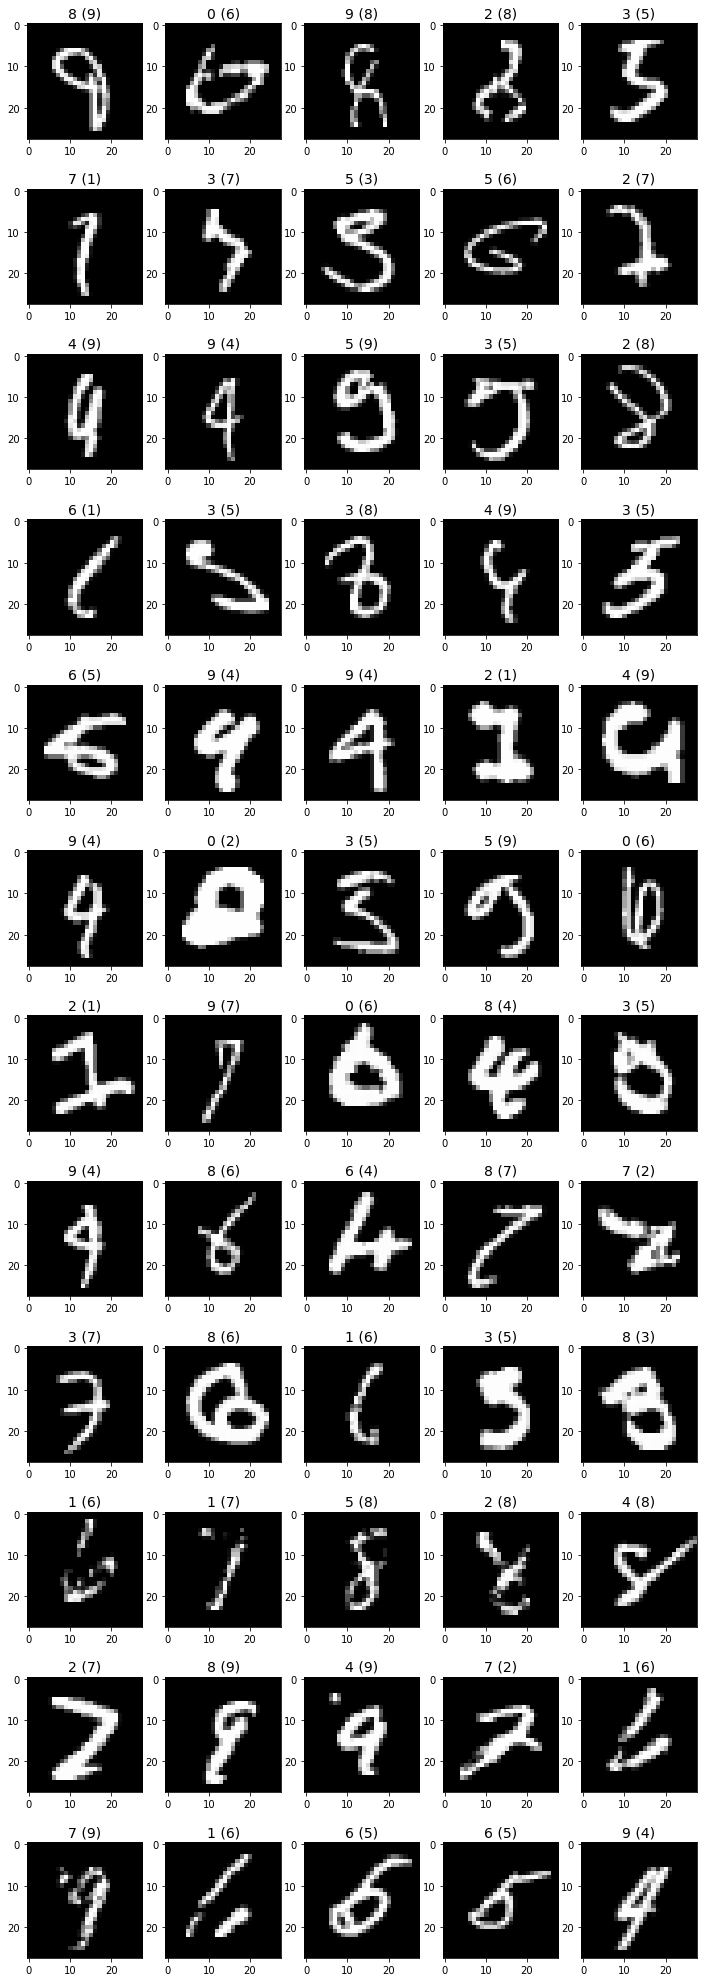

In [69]:
plots(
    mnist.test_input[wrong_answers_idx], 
    titles=predicted_test_labels[wrong_answers_idx], 
    sub_titles = original_test_labels[wrong_answers_idx],
    figsize=(12,36),
    rows=12,
    cmap='gray'
)

# Submit to Kaggle

In [18]:
kaggle_data = [ [idx, predicted_test_labels[idx]] for idx in range(len(predicted_test_labels)) ]

In [19]:
np.savetxt('/data/mnist/v0.3.csv', kaggle_data ,fmt='%d,%d', header='ImageId,Label')